# Masking relationships
#### Adapting from chapter 5 in 'Statistical Rethinking' (from R to Python)

In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import os
from IPython.display import display
from PIL import Image
from theano import shared
import arviz as az

In [2]:
def data_proc():
    
    def standardise(x):
        return (x-x.mean())/x.std()
    
    data = pd.read_csv(os.path.join(os.getcwd(),r'data/milk.csv'), delimiter=";")
    data['kcal_s'] = standardise(data['kcal.per.g'])
    data['neo_s'] = standardise(data['neocortex.perc'])
    data['mass_s'] = standardise(data['mass'])
    
    #return out complete cases 
    return data.dropna(axis=0)

In [3]:
milk = data_proc()

In [4]:
milk.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc,kcal_s,neo_s,mass_s
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16,-0.940041,-2.080196,-0.515812
5,New World Monkey,Alouatta seniculus,0.47,21.22,23.58,55.20,5.25,64.54,-1.063955,-0.508641,-0.382588
6,New World Monkey,A palliata,0.56,29.66,23.46,46.88,5.37,64.54,-0.506340,-0.508641,-0.377744
7,New World Monkey,Cebus apella,0.89,53.41,15.80,30.79,2.51,67.64,1.538249,0.010742,-0.493204
9,New World Monkey,S sciureus,0.92,50.58,22.33,27.09,0.68,68.85,1.724120,0.213470,-0.567082


#### The question here is to what extent energy content of milk, measured here by kilocalories, is related to the percent of the brain mass that is neocortex. Neocortex is the gray, outer part of the brain that is particularly elaborated in mammals and especially primates. We’ll end up needing female body mass as well, to see the masking that hides the relationships among the variables.

#### Model set up:
$$ K_{i} \sim Normal(\mu_{i}, \sigma) $$
$$ \mu_{i} = \alpha + \beta_{N}N_{i} $$
$$ \alpha \sim Normal(0, 1) $$
$$ \beta_{N} \sim Normal(0, 1) $$
$$ \sigma \sim Exponential(1) $$

In [5]:
shared_N = shared(milk["neo_s"].values)
with pm.Model() as m5_5:
    a = pm.Normal('a', mu=0, sigma=1)
    b = pm.Normal('b', mu=0, sigma=1)
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic('mu', a + b*shared_N)
    
    K = pm.Normal('K', mu=mu, sigma=sigma, observed=milk.kcal_s)
    m5_5_trace = pm.sample()

<ipython-input-5-60e370c85e98>:9: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  m5_5_trace = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


#### Examine the appropriateness of priors with prior predictive samples

In [6]:
def plot_priors(model, title):
    shared_N.set_value(np.array([-2, 2]))
    with model:
        model_prior_pred = pm.sample_prior_predictive()
    
    fig, ax = plt.subplots()
    
    for i in range(50):
        ax.plot([-2, 2], model_prior_pred['K'][i], c='blue', alpha=0.3)
    
    ax.set_ylim([-2, 2])
    ax.set_title(title)
    ax.set_xlabel("neocortex percent (std)")
    ax.set_ylabel("kilocal per g (std)")
    plt.show()
    

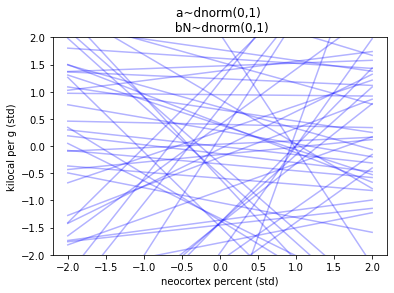

In [7]:
plot_priors(m5_5, title="a~dnorm(0,1) \n bN~dnorm(0,1)")

#### These lines are a mess, indicating that the selection of priors is not good. Let's tighten them up.

In [8]:
shared_N_2 = shared(milk["neo_s"].values)

with pm.Model() as m5_5_2:
    sigma = pm.Exponential("sigma", 1)
    bN = pm.Normal("bN", 0, 0.5)
    a = pm.Normal("a", 0, 0.2)
    mu = pm.Deterministic("mu", a + bN * shared_N_2)

    K = pm.Normal("K", mu, sigma, observed=milk["kcal_s"])

    m5_5_2_trace = pm.sample()

m5_5_data = az.from_pymc3(m5_5_2_trace)

<ipython-input-8-627b3c9c922f>:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  m5_5_2_trace = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bN, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


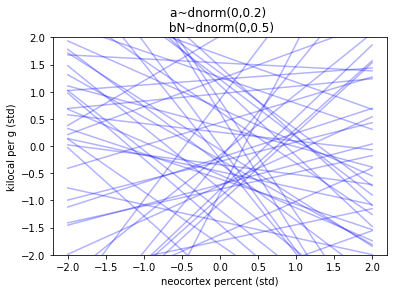

In [9]:
plot_priors(m5_5, title="a~dnorm(0,0.2) \n bN~dnorm(0,0.5)")

In [10]:
varnames=['a', 'bN', 'sigma']
pm.summary(m5_5_2_trace, varnames)

/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.037,0.160,-0.253,0.336,0.002,0.003,5025.0,2650.0,1.0
bN,0.129,0.247,-0.332,0.605,0.004,0.004,4432.0,2594.0,1.0
sigma,1.109,0.204,0.770,1.498,0.003,0.002,4258.0,2594.0,1.0


#### From this summary, you can possibly see that this is neither a strong nor very precise association. The standard deviation is almost twice the posterior mean. But as always, it’s much easier to see this if we draw a picture looking at the posterior predictive fit.

In [11]:

xseq = np.linspace(milk["neo_s"].min() - 0.15, milk["neo_s"].max() + 0.15, 30)
shared_N.set_value(xseq)
with m5_5:
    m5_5_posterior_predictive = pm.sample_posterior_predictive(m5_5_trace, var_names=["mu"], samples=4_000)


In [12]:
mu_mean = m5_5_posterior_predictive["mu"].mean(axis=0)

/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


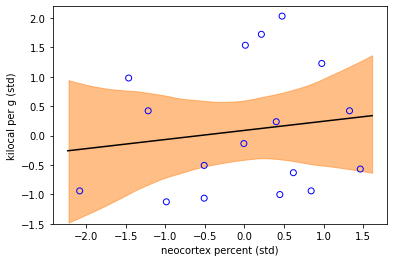

In [13]:
fig, ax = plt.subplots()
az.plot_hdi(xseq, m5_5_posterior_predictive["mu"], ax=ax)
ax.plot(xseq, mu_mean, c="black")
ax.scatter(milk["neo_s"], milk["kcal_s"], facecolors="none", edgecolors="b")
ax.set_ylim(-1.5, 2.2)
ax.set_xlabel("neocortex percent (std)")
ax.set_ylabel("kilocal per g (std)");

#### Now consider another predictor variable, adult female body mass, mass in the dataframe

In [14]:
shared_M = shared(milk["mass_s"].values)


with pm.Model() as m5_6:
    sigma = pm.Exponential("sigma", 1)
    bM = pm.Normal("bM", 0, 0.5)
    a = pm.Normal("a", 0, 0.2)
    mu = pm.Deterministic("mu", a + bM * shared_M)

    K = pm.Normal("K", mu, sigma, observed=milk["kcal_s"])

    m5_6_trace = pm.sample()

m5_6_data = az.from_pymc3(m5_6_trace)

<ipython-input-14-59d0b1d67792>:12: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  m5_6_trace = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bM, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


In [15]:
varnames=['a', 'bM', 'sigma']
pm.summary(m5_6_trace, varnames)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.046,0.160,-0.267,0.330,0.002,0.003,4467.0,2948.0,1.0
bM,-0.308,0.245,-0.765,0.151,0.004,0.003,4363.0,2995.0,1.0
sigma,1.054,0.199,0.712,1.404,0.003,0.002,4212.0,2649.0,1.0


#### mass is negatively correlated with kilocalories. This influence does seem stronger than that of neocortex percent, although in the opposite direction. It is quite uncertain though, with a wide confidence interval that is consistent with a wide range of both weak and stronger relationships

#### Let's regress both variables with the following model specification:
$$ K_{i} \sim Normal(\mu_{i}, \sigma) $$
$$ \mu_{i} = \alpha + \beta_{N}N_{i} + \beta_{M}M_{i}$$ 
$$ \alpha \sim Normal(0, 0.2) $$
$$ \beta_{n} \sim Normal(0, 0.5) $$
$$ \beta_{n} \sim Normal(0, 0.5) $$
$$ \sigma \sim Exponential(1) $$

In [16]:
shared_N = shared(milk['neo_s'].values)
shared_M = shared(milk['mass_s'].values)

with pm.Model() as m5_7:
    sigma = pm.Exponential('sigma', 1)
    bN = pm.Normal('bN', mu=0, sigma=0.5)
    bM = pm.Normal('bM', mu=0, sigma=0.5)
    a = pm.Normal('a', mu=0, sigma=0.2)
    
    mu = pm.Deterministic('mu', a + bN*shared_N + bM*shared_M)
    
    K = pm.Normal('K', mu=mu, sigma=sigma, observed=milk["kcal_s"])
    m5_7_trace = pm.sample(tune=2_000, draws=10_000)

<ipython-input-16-62e712898768>:13: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  m5_7_trace = pm.sample(tune=2_000, draws=10_000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bM, bN, sigma]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 20 seconds.


In [17]:
varnames = ['a', 'bN', 'bM', 'sigma']
pm.summary(m5_7_trace, varnames)

/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.060,0.153,-0.223,0.350,0.001,0.001,33653.0,29662.0,1.0
bN,0.379,0.257,-0.100,0.868,0.002,0.001,24337.0,25240.0,1.0
bM,-0.513,0.269,-1.000,0.002,0.002,0.001,23678.0,25640.0,1.0
sigma,0.970,0.192,0.649,1.327,0.001,0.001,26945.0,23374.0,1.0


In [18]:
m5_7_data = az.from_pymc3(m5_7_trace)

/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


<ipython-input-19-5eb86ba43382>:1: DeprecationWarning: The function `forestplot` from PyMC3 is just an alias for `plot_forest` from ArviZ. Please switch to `pymc3.plot_forest` or `arviz.plot_forest`.
  pm.forestplot(m5_7_trace)


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

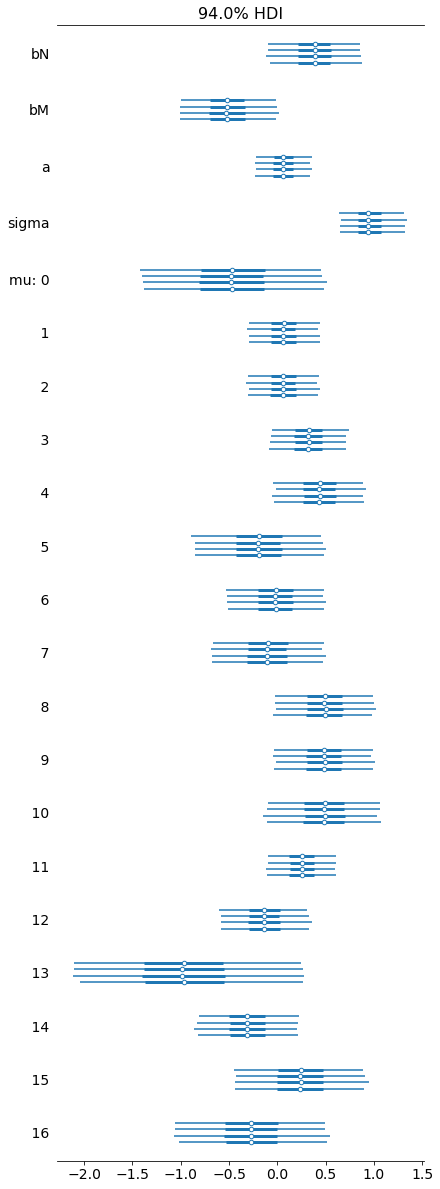

In [19]:
pm.forestplot(m5_7_trace)

#### Comparing estimates between the separate bivariate models and the multiple regression models. We such much larger effect sizes for mass and neocortex variables.  This is a context in which there are two variables correlated with the outcome, but one is positively correlated with it and the other is negatively correlated with it. In addition, both of the explanatory variables are positively correlated with one another.

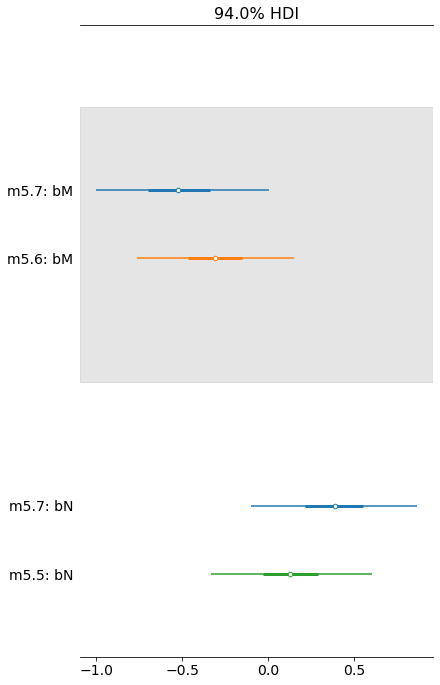

In [20]:
az.plot_forest(
    [m5_7_data, m5_6_data, m5_5_data],
    model_names=["m5.7", "m5.6", "m5.5"],
    var_names=["bM", "bN"],
    combined=True,
);

#### This is another case in which multiple regression automatically finds the most revealing cases and uses them to produce inferences. What the regression model does is ask if species that have high neocortex percent for their body mass have higher milk energy. Likewise, the model asks if species with high body massfor their neocortex percent have higher milk energy. Bigger species, like apes, have milk with less energy. But species with more neocortex tend to have richer milk. The fact that these two variables, body size and neocortex, are correlated across species makes it hard to see these relationships, unless we account for both.


#### Three possible DAGs are consistent with this data, let M be body mass, N by neocortex percent, K by kcals of milk and U be an unobservable.

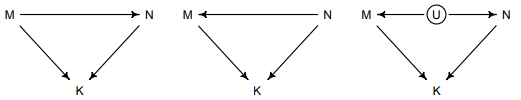

In [21]:
display(Image.open(os.path.join(os.getcwd(),r'data/dag3.png')))

#### The above graphs have the same set of 'conditional independencies' (in this case there are none since the graphs imply that all of the variables are associated regardless of what we condition on. A set of DAGs with the same conditional independencies is known as a 'Markov Equivalence' set.

#### Let’s make counterfactual plots to show how the model sees the problem. Once we have multiple predictor variables, we can conduct counterfactual experiments that vary one predictor while holding the others constant. In the real world, such experiments are typically impossible. If we change an animal’s body size, natural selection will then change the other features to match it. But these counterfactual plots do help us see how the model views the association between each predictor and the outcome.

/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


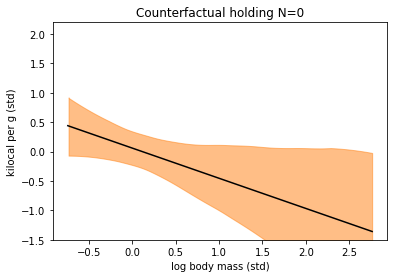

In [22]:
xseq = np.linspace(milk["mass_s"].min() - 0.15, milk["mass_s"].max() + 0.15, 30)
shared_N.set_value(np.zeros(30))
shared_M.set_value(xseq)


with m5_7:
    m5_7_posterior_predictive = pm.sample_posterior_predictive(
        m5_7_trace, var_names=["mu"], samples=4000
    )

mu_mean = m5_7_posterior_predictive["mu"].mean(axis=0)

fig, ax = plt.subplots()
az.plot_hdi(xseq, m5_7_posterior_predictive["mu"], ax=ax)
ax.plot(xseq, mu_mean, c="black")

ax.set_ylim(-1.5, 2.2)
ax.set_title("Counterfactual holding N=0")
ax.set_ylabel("kilocal per g (std)")
ax.set_xlabel("log body mass (std)");